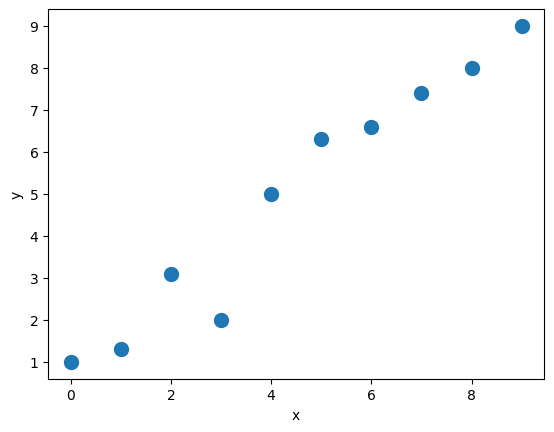

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [4]:
# одномерная линейная регрессия
class MyModel(tf.keras.Model): # наследуем класс, чтобы использовать возможности keras
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name="weight")
        self.b = tf.Variable(0.0, name="bias")

    def call(self, x): # функция генерации выходов модели
        return self.w * x + self.b
    

In [5]:
model = MyModel()
model.build(input_shape=(None, 1)) # построение модели + указание размерности входа
# None - любое число, то есть любое количество образцов, но признак всегда только один
model.summary() # графическое представление модели

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
def loss_fn(y_pred, y_true): # среднеквадратическая ошибка
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train(model, inputs, outputs, learning_rate): # функция обучения
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs) # вычисляем ошибку
    dW, db = tape.gradient(current_loss, [model.w, model.b]) # вычисляем градиенты для весов и смещения
    model.w.assign_sub(learning_rate * dW) # обновляем веса
    model.b.assign_sub(learning_rate * db) # обновляем смещение

In [7]:
num_epochs = 200
log_steps = 100 # количество шагов до логирования ошибки
learning_rate = 0.001
batch_size = 1 
steps_per_epoch = int(np.ceil(len(y_train) / batch_size)) # по сути мы за один шаг обучаемся на все данные, так как их очень мало, но в общем случае на каждом шаге обучаемся только на несколько образцов(batch_size)

In [8]:
ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None) # повторяем выборку до бесконечности
ds_train = ds_train.batch(batch_size=batch_size)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs: # так как набор бесконечный
        break
    # чтобы сохранить число, а не объект Variable
    Ws.append(model.w.numpy())  
    bs.append(model.b.numpy())
    
    batch_x, batch_y = batch # разделение данных на признаки и метки
    loss_val = loss_fn(model(batch_x), batch_y)
    train(model, batch_x, batch_y, learning_rate)
    
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 39.6900
Epoch   10 Step 100 Loss 42.2262
Epoch   20 Step 200 Loss 12.3518
Epoch   30 Step 300 Loss 3.6837
Epoch   40 Step 400 Loss 11.2891
Epoch   50 Step 500 Loss 6.5528
Epoch   60 Step 600 Loss 6.5319
Epoch   70 Step 700 Loss 2.5848
Epoch   80 Step 800 Loss 2.6964
Epoch   90 Step 900 Loss 0.1537
Epoch  100 Step 1000 Loss 0.0211
Epoch  110 Step 1100 Loss 0.0347
Epoch  120 Step 1200 Loss 1.5254
Epoch  130 Step 1300 Loss 0.3784
Epoch  140 Step 1400 Loss 0.1196
Epoch  150 Step 1500 Loss 0.3790
Epoch  160 Step 1600 Loss 0.0904
Epoch  170 Step 1700 Loss 1.0799
Epoch  180 Step 1800 Loss 1.0132
Epoch  190 Step 1900 Loss 2.1818


Final Parameters: 2.6578593 4.8794265


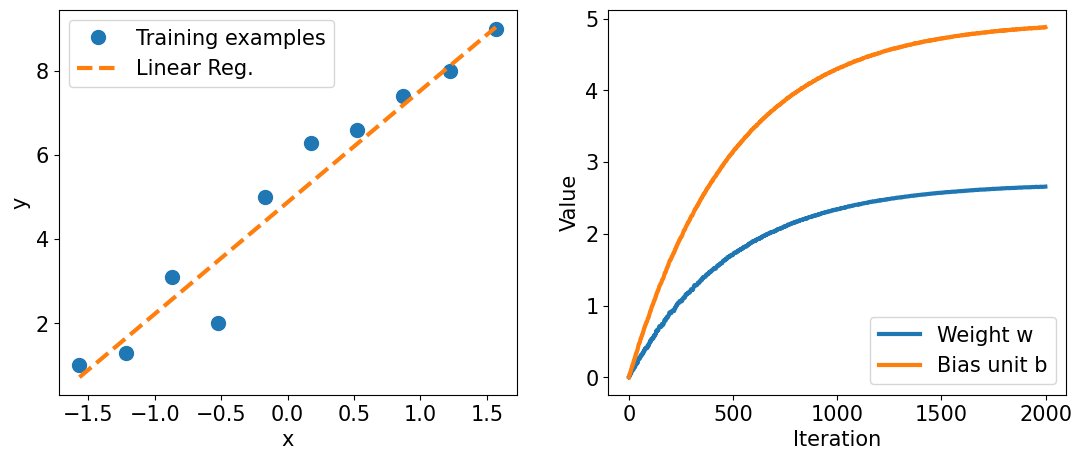

In [9]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [10]:
model = MyModel()
model.compile(optimizer='sgd', loss=loss_fn, metrics=['mse', 'mae']) # можно и loss='mse'

In [11]:
model.fit(X_train_norm, y_train, epochs=num_epochs, verbose=1, batch_size=batch_size) # verbose - уровень логирования процесса обучения

Epoch 1/200
10/10 [==============================] - 0s 2ms/step - loss: 27.8598 - mse: 27.8598 - mae: 4.6098
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 18.6519 - mse: 18.6519 - mae: 3.7289
Epoch 3/200
10/10 [==============================] - 0s 1ms/step - loss: 12.5467 - mse: 12.5467 - mae: 3.0486
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 8.4614 - mse: 8.4614 - mae: 2.4800
Epoch 5/200
10/10 [==============================] - 0s 0s/step - loss: 5.7589 - mse: 5.7589 - mae: 2.0433
Epoch 6/200
10/10 [==============================] - 0s 0s/step - loss: 3.9716 - mse: 3.9716 - mae: 1.7236
Epoch 7/200
10/10 [==============================] - 0s 0s/step - loss: 2.7761 - mse: 2.7761 - mae: 1.4603
Epoch 8/200
10/10 [==============================] - 0s 0s/step - loss: 1.9875 - mse: 1.9875 - mae: 1.2620
Epoch 9/200
10/10 [==============================] - 0s 1ms/step - loss: 1.4615 - mse: 1.4615 - mae: 1.1044    
Epoch 10/200
10/10 [==

In [12]:
import tensorflow_datasets as tfds


iris, iris_info = tfds.load('iris', as_supervised=True, with_info=True)

c:\Users\csr10\OneDrive\Рабочий стол\Work\Learn\ML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
num_epochs = 100
training_size = 100
batch_size = 2

In [14]:
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False) # просто указываем всегда этот параметр, 150 - буффер

ds_orig

<_ShuffleDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# разделение на тренировочную и тестовую выборки
ds_train_orig = ds_orig.take(100)
ds_test_orig = ds_orig.skip(100)

In [16]:
ds_train = ds_train_orig.shuffle(buffer_size=training_size).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE) # короче это оптимизирует процесс
ds_test = ds_test_orig.shuffle(buffer_size=training_size).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(4,)), # 4 - количество признаков, 16 - количество нейронов(случайное)
    tf.keras.layers.Dense(3, activation='softmax')]) # softmax - поддерживает многоклассовую классификацию, 3 - количество нейронов и соответственно классов
# если мы определили input_shape, то уже не надо вызывать build для вызова summary
iris_model.summary()

iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


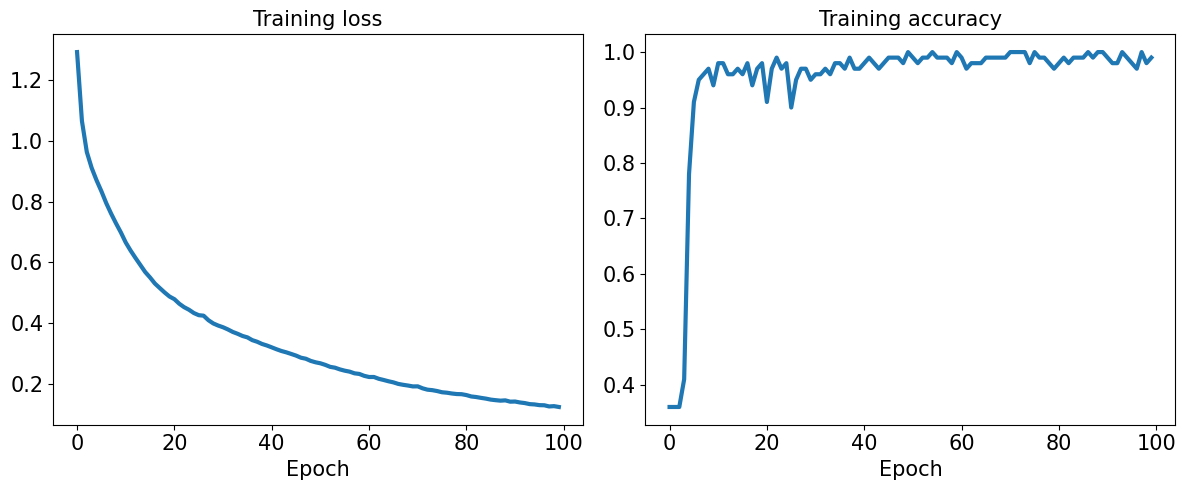

In [18]:
history = iris_model.fit(ds_train, 
                         epochs=num_epochs,
                         validation_data=ds_test,
                         verbose=0)

hist = history.history # история обучения, которая хранится в объекте history. Можно вывести ее и посмотреть, как изменялись параметры в процессе обучения

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()

In [ ]:
results = iris_model.evaluate(ds_test, verbose=0) # оценка на тестовой выборке
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1650   Test Acc.: 0.9600


In [23]:
# сохранить архитектуру и веса модели
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')
# iris_model.save_weights('iris-classifier') # сохранить только веса
# iris_model.save('iris-classifier', save_format='tf') или iris_model.to_json() # сохранить только архитектуру

c:\Users\csr10\OneDrive\Рабочий стол\Work\Learn\ML\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# восстановить архитектуру и веса модели
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
results = iris_model_new.evaluate(ds_test, verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1650   Test Acc.: 0.9600


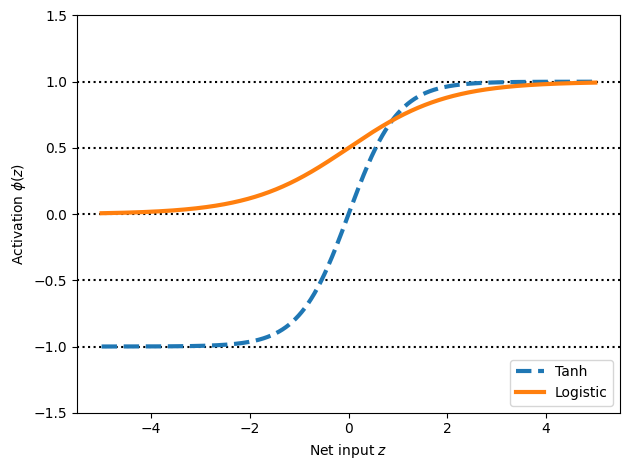

In [27]:
def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()